# Compare Read Stack

https://github.com/Elembio/AvidityManuscript2023/blob/701be395c892d00beca69693536ad600d209eec2/notebooks/compare_read_stack.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/stack_reads")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

In [2]:
doff = []
columns = ["chr", "pos", "errors", "bases", "error_rate"]
for file in basedir.rglob("*/*.offset-error.tsv"):
    d = pd.read_csv(file, sep="\t", names=columns)
    strat = file.name.split(".")[0]
    if strat.startswith("GRCh38_SimpleRepeat_"):
        strat = "_".join(strat.split("_")[2:-1])

    d["stratification"] = strat
    d["run"] = file.parent.parent.stem
    d["Cell line"] = file.parent.stem
    doff.append(d)

doff = pd.concat(doff).reset_index(drop=True)

# Adjust downstream postions to start from 1 instead of 0
doff.query("pos >= 0")["pos"] = doff.query("pos >= 0")["pos"] + 1

# Filter out postions more than 100 bp away
doff = doff.query("abs(pos) < 100")

# Annotate by potions into downstream vs upstream
doff["location"] = pd.cut(doff["pos"], bins=[-100, -1, 100], labels=["Upstream", "Downstream"])

# Filter out low coverage stratifications
d = doff.groupby(["stratification", "run", "Cell line"], as_index=False)["bases"].sum()
low_cov = d[d["bases"] < 2*50*100]["stratification"].unique().tolist()
print("Low cov stratifications:\n -", "\n - ".join(low_cov))

doff["Data source"] = doff["run"].replace(run_names)
doff.head()

    

Low cov stratifications:
 - homopolymer_ge21_GC
 - triTR_50to149


,chr,pos,errors,bases,error_rate,stratification,run,Cell line,location,Data source
13,chr20,-99,0,3.0,0.0,homopolymer_ge21_GC,aviti_hq,REH,Upstream,AVITI CB
14,chr20,-98,0,3.0,0.0,homopolymer_ge21_GC,aviti_hq,REH,Upstream,AVITI CB
15,chr20,-97,0,3.0,0.0,homopolymer_ge21_GC,aviti_hq,REH,Upstream,AVITI CB
16,chr20,-96,0,3.0,0.0,homopolymer_ge21_GC,aviti_hq,REH,Upstream,AVITI CB
17,chr20,-95,0,3.0,0.0,homopolymer_ge21_GC,aviti_hq,REH,Upstream,AVITI CB


<Axes: xlabel='bases', ylabel='stratification'>

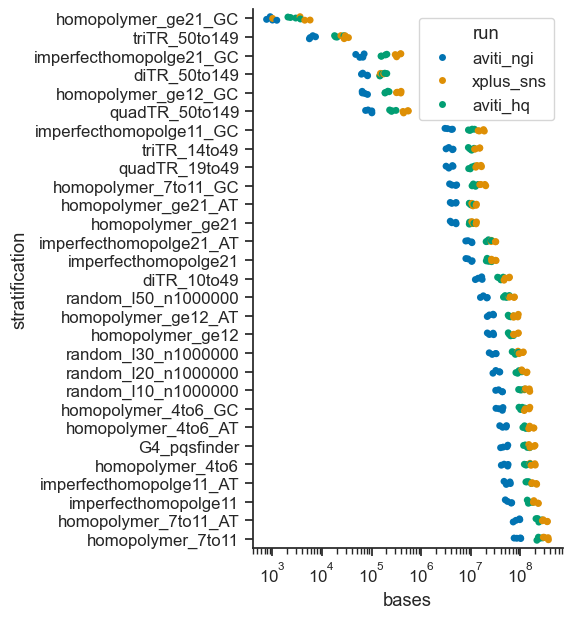

In [3]:
fig, ax = plt.subplots(figsize=(4,7))
sns.stripplot(d.sort_values(by="bases"), y="stratification", x="bases", hue="run", ax=ax, log_scale=True)

## Plot G4

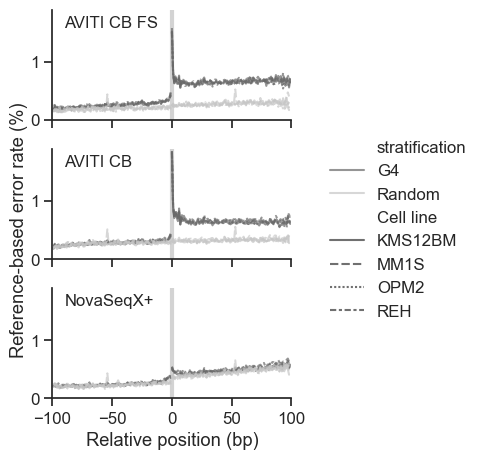

In [4]:

strats = {
    "G4_pqsfinder": "G4",
    "random_l30_n1000000": "Random",
}
d = doff[doff["stratification"].isin(strats.keys())]
#d = d.query("abs(pos) > 1")
d["stratification"] = d["stratification"].replace(strats)
g = sns.relplot(
    d, x="pos", y="error_rate", row="Data source", style="Cell line", hue="stratification",
    row_order=run_names.values(), style_order=sorted(d["Cell line"].unique()),
    alpha=0.7, kind="line", height=4.8/3, aspect=2, palette="Greys_r",
    units="location",
) 

g.set(
    ylabel="", 
    xlabel="Relative position (bp)",
    xlim=(-100, 100),
    ylim=(0, 1.9),
)
g.set_titles("")
for s, ax in g.axes_dict.items():
    ax.text(.05, .95, s, transform=ax.transAxes, va="top", size=12)
# Add common ylabel
g.fig.text(0, 0.5, "Reference-based error rate (%)", va="center", rotation="vertical")
#g.fig.subplots_adjust(hspace=0, wspace=0.1)
g.refline(x=0, color="lightgrey", lw=3, ls="-",  zorder=-1)

g.savefig(figdir / "g4_vs_random_error_rate.svg", dpi=300, bbox_inches="tight", transparent=True)


## Plot all strip

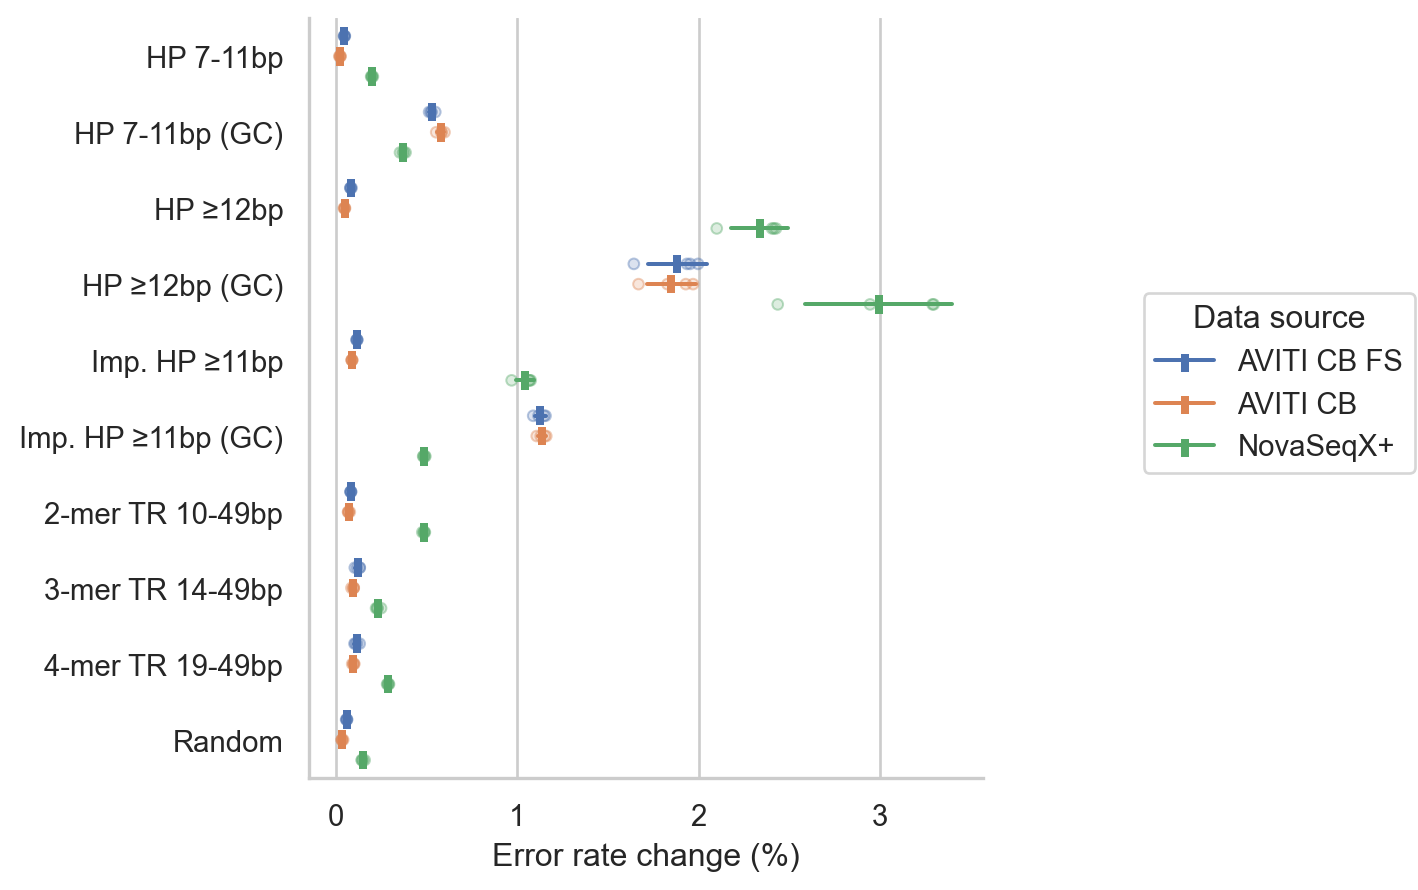

In [5]:
col_order = {
    'homopolymer_7to11': "HP 7-11bp",
    'homopolymer_7to11_GC': "HP 7-11bp (GC)",
    'homopolymer_ge12': "HP ≥12bp",
    'homopolymer_ge12_GC': "HP ≥12bp (GC)",
    'imperfecthomopolge11': "Imp. HP ≥11bp",
    'imperfecthomopolge11_GC': "Imp. HP ≥11bp (GC)",
    'diTR_10to49': "2-mer TR 10-49bp",
    'triTR_14to49': "3-mer TR 14-49bp",
    'quadTR_19to49': "4-mer TR 19-49bp",
    'random_l30_n1000000': "Random",
}
d = doff[doff["stratification"].isin(col_order)].copy()
d = d.query("abs(pos) < 50")

d = d.groupby(["stratification", "location", "Data source", "Cell line"]).agg({
    "bases": "sum",
    "errors": "sum",
}).reset_index()

d["error_rate"] = 100 * d["errors"] / d["bases"]

# Calculate error rate change vs upstream
d["notup"] = d["location"].apply(lambda x: 1 if x != "Upstream" else 0)
d = d.sort_values(by="notup")
d["error_change"] = d.groupby(["stratification", "Data source", "Cell line"])["error_rate"].transform(
    lambda x: x - x.iloc[0]
)

# Remove upstream
d = d[d["notup"] == 1].copy()
d["location"] = d["location"].cat.remove_unused_categories()
d = d.sort_values(by="Data source")
d["stratification"] = d["stratification"].replace(col_order)
p = (
    so.Plot(data=d, x="error_change", y="stratification", color="Data source")#, group="Cell line")
    .facet(col="location").share(x=False)
    
    # Plot cells
    .add(so.Dots(pointsize=4, alpha=0.4), so.Dodge(by=["color"], gap=0), legend=False)

    # Plot means with error bars
    .add(so.Dot(marker="|", pointsize=7, stroke=3), so.Est("mean"), so.Dodge(by=["color"], gap=0))
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge(by=["color"], gap=0))

    .scale(
        color=so.Nominal(order=list(run_names.values())),
        marker=so.Nominal(order=sorted(d["Cell line"].unique())),
        y=so.Nominal(order=list(col_order.values())),
    )
    .layout(size=(6, 4.8), engine="tight", extent=[0, 0, 0.9, 1])
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("notebook"))
    .theme(custom_params)
    .label(
        x="Error rate change (%)",
        y="",
        #title="Upstream vs. {}".format,
        title=""
    )
    .save(figdir / "error_rate_change_repeats.svg", dpi=300, bbox_inches="tight", transparent=True)
)
p
